In [1]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, accuracy_score, roc_auc_score

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

%matplotlib inline

### Importing Data

In [2]:
train = pd.read_csv('./assets/train.csv')
test = pd.read_csv('./assets/test.csv')
spray = pd.read_csv('./assets/spray.csv')
weather = pd.read_csv('./assets/weather.csv')

#### Convert Date columns to DateTime Object and Reindex

In [3]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
weather["Date"] = pd.to_datetime(weather["Date"])
spray["Date"] = pd.to_datetime(spray["Date"])

train.set_index("Date", inplace=True)
test.set_index("Date", inplace=True)
weather.set_index("Date", inplace=True)
spray.set_index("Date", inplace=True)

#### Converting 'Trap' column to a numerical column

In [4]:
train['Trap'] = train['Trap'].str.replace('T', '')
train['Trap'] = train['Trap'].str.replace('B', '.2')
train['Trap'] = train['Trap'].str.replace('C', '.3')
train['Trap'] = train['Trap'].astype(float)

test['Trap'] = test['Trap'].str.replace('T', '')
test['Trap'] = test['Trap'].str.replace('A', '.1')
test['Trap'] = test['Trap'].str.replace('B', '.2')
test['Trap'] = test['Trap'].str.replace('C', '.3')
test['Trap'] = test['Trap'].astype(float)

#### Replacing the missing values with the value immediately preceding or following it in the dataframe
- Having done a little digging, it looks like weather station 2 has the majority of the missing values. By using the 'ffill' and 'bfill' methods, I can replace those missing values with the value immediately preceding or following the missing value in the dataframe. In this case it will replace the missing value for station 2 with the recorded value for that day from station 1. It also appears that station 1 does also have some missing values. I looked at these pretty carefully and tried to fill appropriately. While this may not be exactly accurate, I believe it will be better than using a mean or median value as both weather stations are in the same city.

In [5]:
weather['Tavg'].replace(to_replace='M', value=None, inplace=True, method='ffill')
weather['Tavg'] = weather['Tavg'].astype(int)

In [6]:
weather['Heat'].replace(to_replace='M', value=None, inplace=True, method='ffill')
weather['Cool'].replace(to_replace='M', value=None, inplace=True, method='ffill')
weather['Heat'] = weather['Heat'].astype(int)
weather['Cool'] = weather['Cool'].astype(int)

In [7]:
weather['Depart'].replace(to_replace='M', value=None, inplace=True, method='ffill')
weather['Depart'] = weather['Depart'].astype(int)

In [8]:
weather['WetBulb'].replace(to_replace='M', value=None, inplace=True, method='bfill')
weather['WetBulb'] = weather['WetBulb'].astype(int)

In [9]:
weather['Sunrise'].replace(to_replace='-', value=None, inplace=True, method='ffill')
weather['Sunrise'] = weather['Sunrise'].astype(float)

In [10]:
weather['Sunset'].replace(to_replace='-', value=None, inplace=True, method='ffill')
weather['Sunset'] = weather['Sunset'].astype(float)

In [11]:
weather['Depth'].replace(to_replace='M', value=0, inplace=True)
weather['Depth'] = weather['Depth'].astype(int)

In [12]:
weather.drop(labels='Water1', axis=1, inplace=True)

In [13]:
weather['SnowFall'].replace(to_replace='M', value=None, inplace=True, method='ffill')
weather['SnowFall'].replace(to_replace='  T', value=0.01, inplace=True)
weather['SnowFall'] = weather['SnowFall'].astype(float)

In [14]:
weather['PrecipTotal'].replace(to_replace='  T', value=.001, inplace=True)
weather['PrecipTotal'].replace(to_replace='M', value=0, inplace=True)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [15]:
weather['StnPressure'].replace(to_replace='M', value=None, inplace=True, method='bfill')
weather['StnPressure'] = weather['StnPressure'].astype(float)

In [16]:
weather['SeaLevel'].replace(to_replace='M', value=None, inplace=True, method='bfill')
weather['SeaLevel'] = weather['SeaLevel'].astype(float)

In [17]:
weather['AvgSpeed'].replace(to_replace='M', value=None, inplace=True, method='bfill')
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

#### I'm not sure what to do with 'CodeSum' yet.
- At first I thought it was not important and pretty sparse. However, it looks like there are 1335 rows that have an entry under this column. I could dummy them out but that would add a lot of colums. I'm going to leave them out of the clean weather csv I create for now. But we can revisit this later.

In [18]:
len(weather[weather['CodeSum'] != ' '])

1335

In [19]:
weather.drop(labels='CodeSum', axis=1, inplace=True)

In [20]:
weather.dtypes

Station          int64
Tmax             int64
Tmin             int64
Tavg             int64
Depart           int64
DewPoint         int64
WetBulb          int64
Heat             int64
Cool             int64
Sunrise        float64
Sunset         float64
Depth            int64
SnowFall       float64
PrecipTotal    float64
StnPressure    float64
SeaLevel       float64
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
dtype: object

#### Pushing clean, numerical dataframe to csv

In [21]:
weather.to_csv('weather_numerical.csv')

#### Importing clean training data

In [22]:
train_clean = pd.read_csv('./clean_train_v3.csv')

#### Merging training and weather data

In [23]:
station_1 = weather[weather['Station'] == 1]

In [24]:
station_2 = weather[weather['Station'] == 2]

In [25]:
weather_merge = pd.merge(station_1, station_2, on='Date', suffixes=('_station1', '_station2'))

In [26]:
train_clean.drop('Unnamed: 0', axis=1, inplace=True)
train_clean.head()

,Date,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Coordinates
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469)
1,2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469)
2,2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,1,0,POINT (-87.769279 41.994991)
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,1,0,POINT (-87.82481199999999 41.974089)
4,2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,4,0,POINT (-87.82481199999999 41.974089)


In [27]:
train_clean["Date"] = pd.to_datetime(train_clean["Date"])
train_clean.set_index("Date", inplace=True)

In [28]:
train_clean.head()

,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Coordinates
Date,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469)
2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469)
2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,1,0,POINT (-87.769279 41.994991)
2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,1,0,POINT (-87.82481199999999 41.974089)
2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,4,0,POINT (-87.82481199999999 41.974089)


In [29]:
tw_df = pd.merge(train_clean, weather_merge, how='left', left_index=True, right_index=True)

In [65]:
tw_df.tail()

,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Coordinates,Tmax_station1,Tmin_station1,...,Cool_station2,Sunrise_station2,Sunset_station2,SnowFall_station2,PrecipTotal_station2,StnPressure_station2,SeaLevel_station2,ResultSpeed_station2,ResultDir_station2,AvgSpeed_station2
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-26,CULEX PIPIENS/RESTUANS,51,T035,41.763733,-87.742302,6,1,POINT (-87.742302 41.763733),75,50,...,0,543.0,1742.0,0.0,0.0,29.4,30.04,4.1,9,4.6
2013-09-26,CULEX PIPIENS/RESTUANS,58,T231,41.987280,-87.666066,5,0,POINT (-87.666066 41.98728),75,50,...,0,543.0,1742.0,0.0,0.0,29.4,30.04,4.1,9,4.6
2013-09-26,CULEX PIPIENS/RESTUANS,17,T232,41.912563,-87.668055,1,0,POINT (-87.66805500000001 41.912563),75,50,...,0,543.0,1742.0,0.0,0.0,29.4,30.04,4.1,9,4.6
2013-09-26,CULEX PIPIENS/RESTUANS,71,T233,42.009876,-87.807277,5,0,POINT (-87.807277 42.009876),75,50,...,0,543.0,1742.0,0.0,0.0,29.4,30.04,4.1,9,4.6
2013-09-26,CULEX PIPIENS/RESTUANS,42,T235,41.776428,-87.627096,1,0,POINT (-87.62709599999999 41.776428),75,50,...,0,543.0,1742.0,0.0,0.0,29.4,30.04,4.1,9,4.6


In [31]:
tw_df.drop(labels=['Station_station1', 'Station_station2'], axis=1, inplace=True)

In [32]:
tw_df.drop(labels=['Depth_station1', 'Depth_station2'], axis=1, inplace=True)

#### Exporting merged train and weather data to csv

In [33]:
tw_df.to_csv('updated_train_and_weather.csv')

In [34]:
wnv = train[train['WnvPresent'] == 1]

In [35]:
wnv_2007 = wnv['2007']

In [36]:
wnv_2007.to_csv('wnv_2007.csv')

In [37]:
wnv_2009 = wnv['2009']

In [38]:
wnv_2009.to_csv('wnv_2009.csv')

In [39]:
wnv_2011 = wnv['2011']
wnv_2011.to_csv('wnv_2011.csv')

In [40]:
wnv_2013 = wnv['2013']
wnv_2013.to_csv('wnv_2013.csv')

In [41]:
spray_2011 = spray['2011']
spray_2011.to_csv('spray_2011.csv')

In [42]:
nownv = train[train['WnvPresent'] == 0]

In [43]:
nownv_2007 = nownv['2007']
nownv_2007.to_csv('nownv_2007.csv')

In [44]:
spray_2013 = spray['2013']
spray_2013.to_csv('spray_2013.csv')

### Modeling

In [45]:
tw_df.head()

,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Coordinates,Tmax_station1,Tmin_station1,...,Cool_station2,Sunrise_station2,Sunset_station2,SnowFall_station2,PrecipTotal_station2,StnPressure_station2,SeaLevel_station2,ResultSpeed_station2,ResultDir_station2,AvgSpeed_station2
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469),88,60,...,12,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16,7.4
2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,1,0,POINT (-87.800991 41.95469),88,60,...,12,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16,7.4
2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,1,0,POINT (-87.769279 41.994991),88,60,...,12,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16,7.4
2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,1,0,POINT (-87.82481199999999 41.974089),88,60,...,12,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16,7.4
2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,4,0,POINT (-87.82481199999999 41.974089),88,60,...,12,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16,7.4


In [46]:
tw_df.corr().abs()

,Block,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax_station1,Tmin_station1,Tavg_station1,Depart_station1,DewPoint_station1,...,Cool_station2,Sunrise_station2,Sunset_station2,SnowFall_station2,PrecipTotal_station2,StnPressure_station2,SeaLevel_station2,ResultSpeed_station2,ResultDir_station2,AvgSpeed_station2
Block,1.000000,0.091110,0.090375,0.172388,0.004877,0.002966,0.010909,0.005240,0.002674,0.004021,...,0.009351,0.006206,0.002874,0.021321,0.006770,0.007284,0.002545,0.009553,0.023944,0.011857
Latitude,0.091110,1.000000,0.701795,0.184806,0.028697,0.068892,0.095609,0.087314,0.084894,0.062183,...,0.086742,0.067468,0.036795,0.035097,0.010194,0.017763,0.005370,0.029988,0.006938,0.002775
Longitude,0.090375,0.701795,1.000000,0.036633,0.060345,0.084255,0.100828,0.099078,0.105610,0.085279,...,0.094155,0.076936,0.050656,0.027922,0.027170,0.016802,0.004244,0.027961,0.007823,0.006383
NumMosquitos,0.172388,0.184806,0.036633,1.000000,0.196820,0.163188,0.192904,0.189484,0.104274,0.160362,...,0.182304,0.044844,0.088884,0.024226,0.016135,0.027699,0.047220,0.005572,0.038607,0.031088
WnvPresent,0.004877,0.028697,0.060345,0.196820,1.000000,0.050536,0.072719,0.066043,0.055436,0.090460,...,0.056728,0.105227,0.068451,0.030886,0.039370,0.011917,0.007322,0.040141,0.007983,0.028088
Tmax_station1,0.002966,0.068892,0.084255,0.163188,0.050536,1.000000,0.748646,0.940312,0.813607,0.737613,...,0.888442,0.116676,0.220346,0.046602,0.039699,0.266597,0.307704,0.095371,0.135139,0.065747
Tmin_station1,0.010909,0.095609,0.100828,0.192904,0.072719,0.748646,1.000000,0.928568,0.694328,0.894011,...,0.875833,0.182519,0.289458,0.066535,0.209882,0.403657,0.453685,0.016568,0.129885,0.088646
Tavg_station1,0.005240,0.087314,0.099078,0.189484,0.066043,0.940312,0.928568,1.000000,0.808653,0.866484,...,0.943828,0.159583,0.271423,0.055247,0.085532,0.357730,0.406755,0.063702,0.138021,0.008551
Depart_station1,0.002674,0.084894,0.105610,0.104274,0.055436,0.813607,0.694328,0.808653,1.000000,0.716551,...,0.810037,0.287180,0.230890,0.052788,0.012653,0.224357,0.264588,0.027311,0.102865,0.050086
DewPoint_station1,0.004021,0.062183,0.085279,0.160362,0.090460,0.737613,0.894011,0.866484,0.716551,1.000000,...,0.832860,0.071587,0.172858,0.100111,0.332264,0.449949,0.489482,0.026840,0.126426,0.086924


In [47]:
nownv = tw_df[tw_df['WnvPresent'] == 0]
nowwnv_traps = nownv['Trap'].unique()

wnv = tw_df[tw_df['WnvPresent'] == 1]
wnv_traps = wnv['Trap'].unique()

tw_df['Trap']

Date
2007-05-29    T002
2007-05-29    T002
2007-05-29    T007
2007-05-29    T015
2007-05-29    T015
2007-05-29    T045
2007-05-29    T046
2007-05-29    T048
2007-05-29    T048
2007-05-29    T049
2007-05-29    T050
2007-05-29    T054
2007-05-29    T054
2007-05-29    T086
2007-05-29    T086
2007-05-29    T091
2007-05-29    T094
2007-05-29    T096
2007-05-29    T096
2007-05-29    T129
2007-05-29    T129
2007-05-29    T143
2007-05-29    T148
2007-05-29    T153
2007-05-29    T159
2007-06-05    T002
2007-06-05    T002
2007-06-05    T002
2007-06-05    T015
2007-06-05    T015
              ... 
2013-09-26    T102
2013-09-26    T102
2013-09-26    T102
2013-09-26    T027
2013-09-26    T221
2013-09-26    T221
2013-09-26    T221
2013-09-26    T009
2013-09-26    T900
2013-09-26    T900
2013-09-26    T900
2013-09-26    T900
2013-09-26    T900
2013-09-26    T900
2013-09-26    T222
2013-09-26    T223
2013-09-26    T223
2013-09-26    T225
2013-09-26    T227
2013-09-26    T227
2013-09-26    T224
2013-09

In [48]:
prominent_traps = tw_df.groupby('Trap')['NumMosquitos'].mean().sort_values(ascending=False)
prom_traps_wnv  = tw_df.groupby('Trap')['WnvPresent'].mean().sort_values(ascending=False)

In [49]:
mosq_density_by_traps = pd.DataFrame(prominent_traps)
wnv_density_by_traps  = pd.DataFrame(prom_traps_wnv)

In [50]:
nownv_traps = wnv_density_by_traps[wnv_density_by_traps['WnvPresent'] == 0]

In [51]:
nownv_traps.index

Index(['T007', 'T229', 'T034', 'T161', 'T018', 'T004', 'T206', 'T237', 'T017',
       'T238', 'T025', 'T019', 'T219', 'T129', 'T040', 'T078', 'T100', 'T099',
       'T141', 'T094B', 'T092', 'T146', 'T088', 'T148', 'T149', 'T150', 'T076',
       'T043', 'T075', 'T072', 'T071', 'T153', 'T157', 'T060', 'T051', 'T050',
       'T046', 'T044', 'T001'],
      dtype='object', name='Trap')

In [52]:
tw_df['Trap'].values

array(['T002', 'T002', 'T007', ..., 'T232', 'T233', 'T235'], dtype=object)

In [53]:
# Merge these dataFrames on index - Maybe create an interaction term that trap importance.  
trap_df = mosq_density_by_traps.join(wnv_density_by_traps)
trap_df.head()
#trap_df.reset_index(inplace=True)
#trap_df['trap_power'] = trap_df['NumMosquitos'] * trap_df['WnvPresent']
#trap_df.drop(columns='trap_power', inplace=True)

,NumMosquitos,WnvPresent
Trap,,
T115,39.977860,0.075646
T103,36.000000,0.072289
T138,31.643312,0.050955
T128,20.718750,0.068750
T900,20.514667,0.088000


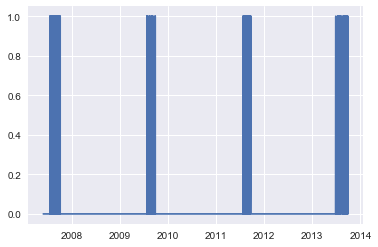

In [54]:
plt.plot(tw_df['WnvPresent'])

In [55]:
tw_df['WnvPresent'].mean()

0.05244622120692937

In [56]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

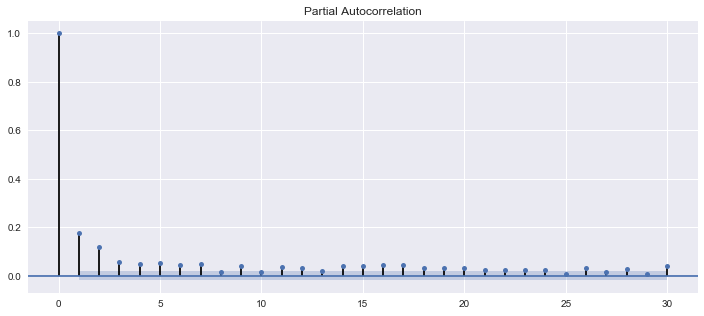

In [57]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(tw_df['WnvPresent'], lags=30, ax=ax)
plt.show()

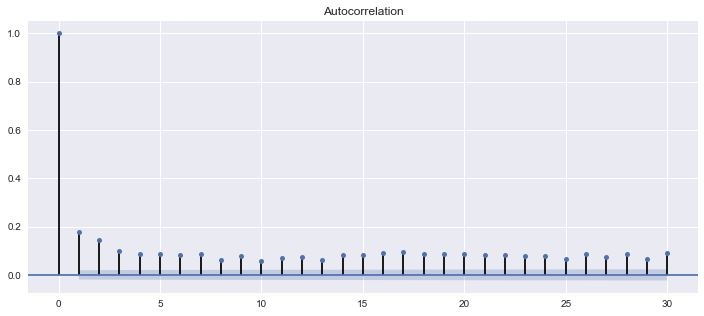

In [58]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(tw_df['WnvPresent'], lags=30, ax=ax)
plt.show()

In [61]:
trap_df['WnvPresent'].sort_values(ascending=False)

Trap
T143     0.193548
T006     0.166667
T005     0.142857
T233     0.140000
T014     0.133333
T096     0.120000
T003     0.114754
T015     0.114286
T235     0.112903
T054C    0.111111
T230     0.107692
T225     0.106796
T016     0.106061
T223     0.103448
T070     0.100000
T002     0.097297
T228     0.096774
T013     0.096154
T154     0.095238
T231     0.095238
T086     0.093023
T107     0.090909
T900     0.088000
T045     0.085714
T011     0.082707
T082     0.081633
T009     0.081081
T221     0.080357
T061     0.077670
T028     0.076923
           ...   
T150     0.000000
T129     0.000000
T044     0.000000
T219     0.000000
T051     0.000000
T078     0.000000
T018     0.000000
T141     0.000000
T001     0.000000
T060     0.000000
T148     0.000000
T043     0.000000
T072     0.000000
T206     0.000000
T237     0.000000
T046     0.000000
T076     0.000000
T004     0.000000
T238     0.000000
T161     0.000000
T088     0.000000
T092     0.000000
T050     0.000000
T146     0.000000
T229 

In [64]:
train[tw_df['Trap'] == 'T006']

,Species,Block,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Coordinates,Tmax_station1,Tmin_station1,...,Cool_station2,Sunrise_station2,Sunset_station2,SnowFall_station2,PrecipTotal_station2,StnPressure_station2,SeaLevel_station2,ResultSpeed_station2,ResultDir_station2,AvgSpeed_station2
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-26,CULEX PIPIENS/RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),92,70,...,17,418.0,1931.0,0.0,0.001,29.45,30.09,7.3,21,8.1
2007-06-26,CULEX RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),92,70,...,17,418.0,1931.0,0.0,0.001,29.45,30.09,7.3,21,8.1
2007-06-29,CULEX RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),70,56,...,0,419.0,1931.0,0.0,0.000,29.47,30.11,7.4,2,8.2
2007-07-02,CULEX RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),79,53,...,3,420.0,1931.0,0.0,0.000,29.55,30.21,7.4,12,8.5
2007-07-11,CULEX PIPIENS/RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),77,62,...,5,426.0,1928.0,0.0,0.000,29.28,29.92,9.1,30,11.2
2007-07-11,CULEX RESTUANS,60,T006,41.990284,-87.797127,2,0,POINT (-87.797127 41.990284),77,62,...,5,426.0,1928.0,0.0,0.000,29.28,29.92,9.1,30,11.2
2007-07-18,CULEX RESTUANS,60,T006,41.990284,-87.797127,3,0,POINT (-87.797127 41.990284),85,69,...,12,432.0,1924.0,0.0,0.920,29.18,29.83,10.3,24,10.6
2007-07-27,CULEX PIPIENS/RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),83,70,...,12,440.0,1917.0,0.0,0.040,29.16,29.80,1.2,36,8.1
2007-07-27,CULEX RESTUANS,60,T006,41.990284,-87.797127,1,0,POINT (-87.797127 41.990284),83,70,...,12,440.0,1917.0,0.0,0.040,29.16,29.80,1.2,36,8.1
